# Data

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load Data
path = '../datasets/'
df = pd.read_csv(path+'tw_pt.csv', usecols=['Text', 'Classificacao'])
df.head()

,Text,Classificacao
0,���⛪ @ Catedral de Santo Antônio - Governador ...,Neutro
1,"� @ Governador Valadares, Minas Gerais https:/...",Neutro
2,"�� @ Governador Valadares, Minas Gerais https:...",Neutro
3,��� https://t.co/BnDsO34qK0,Neutro
4,��� PSOL vai questionar aumento de vereadores ...,Negativo


In [3]:
df.tail()

,Text,Classificacao
8194,"Trio é preso suspeito de roubo, tráfico e abus...",Positivo
8195,"Trio é preso suspeito de roubo, tráfico e abus...",Positivo
8196,"Trio é preso suspeito de roubo, tráfico e abus...",Positivo
8197,"Trio é preso suspeito de roubo, tráfico e abus...",Positivo
8198,Trio suspeito de roubo de cargas é preso em Sa...,Positivo


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8199 entries, 0 to 8198
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Text           8199 non-null   object
 1   Classificacao  8199 non-null   object
dtypes: object(2)
memory usage: 128.2+ KB


# Exploratory Data Analysis

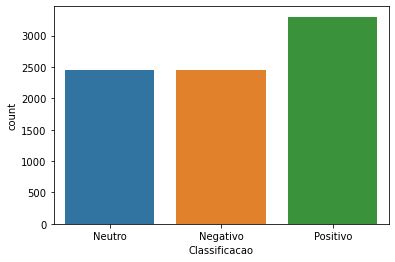

In [5]:
# inspect sentiment
sns.countplot(df['Classificacao']);

In [6]:
# text length
df['text_length'] = df['Text'].apply(len)
df.head()

,Text,Classificacao,text_length
0,���⛪ @ Catedral de Santo Antônio - Governador ...,Neutro,82
1,"� @ Governador Valadares, Minas Gerais https:/...",Neutro,62
2,"�� @ Governador Valadares, Minas Gerais https:...",Neutro,63
3,��� https://t.co/BnDsO34qK0,Neutro,27
4,��� PSOL vai questionar aumento de vereadores ...,Negativo,126


In [7]:
df['text_length'].describe()

count    8199.000000
mean      116.462739
std        22.058911
min        15.000000
25%       100.000000
50%       120.000000
75%       137.000000
max       140.000000
Name: text_length, dtype: float64

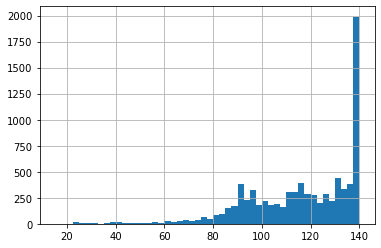

In [8]:
df['text_length'].hist(bins=50);

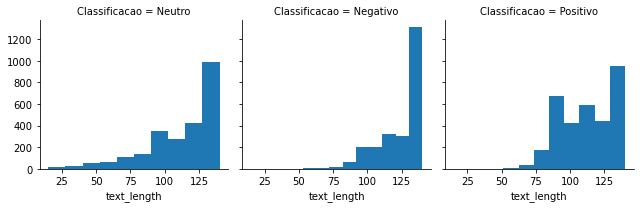

In [9]:
g = sns.FacetGrid(df,col='Classificacao')
g.map(plt.hist,'text_length');

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FABIO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


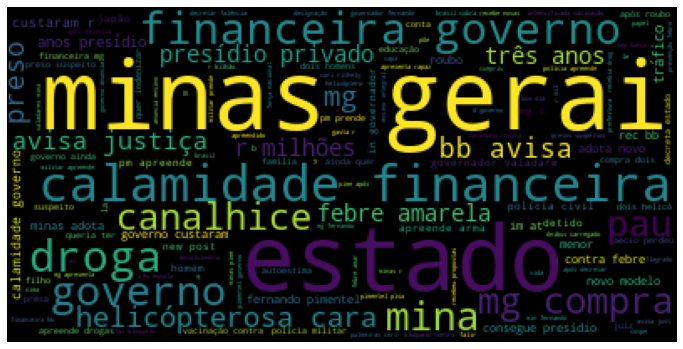

In [10]:
# word cloud
import nltk
nltk.download('stopwords')
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re

def clean_text(s):
    #if type(s)!=str:
     #return ""
    s = re.sub(r'-', ' ', s)    
    s = re.sub(r'/MG', ' MG ', s)    # substitui ?MG por ' MG '    
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s) # remove re-tweet
    s = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', s)  # remove hash tags
    s = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', s)  # remove tweeted at
    s = re.sub(r'-', ' ', s)    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    pattern = r'[^a-zA-z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ\s]' # remove os caracteres especiais mantendo a acentuação em português
    s = re.sub(pattern, '', s)
    s = special_char_pattern.sub(" \\1 ", s)    
    s = re.sub(r"http[s]?://\S+", "", s)
    s = re.sub(r'http\S+', '', s)
    s = re.sub('([0-9]+)', '', s)  # remove numbers
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    s = re.sub(r'[\r|\n|\r\n]+', ' ', s)
    s = re.sub(' +', ' ', s)
    soup = BeautifulSoup(s, "html.parser")
    s = soup.get_text()
    s = re.sub(r"\s+"," ",s).strip()
    return s
df['clean_tweet'] = df['Text'].apply(clean_text).str.lower()

text = df['clean_tweet'].to_string().lower()    
wordcloud = WordCloud(
    collocations=True,
    relative_scaling=0.5,
    stopwords=set(stopwords.words('portuguese'))).generate(text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [11]:
# df.head()

# Data Preprocessing

In [12]:
# Encode Categorical Variable
X = df['clean_tweet']
y = pd.get_dummies(df['Classificacao']).values
num_classes = df['Classificacao'].nunique()
y

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [13]:
seed = 101 # fix random seed for reproducibility
np.random.seed(seed)

In [14]:
# Split Train Test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6559,) (1640,) (6559, 3) (1640, 3)


In [15]:
# Tokenize Text
from tensorflow.keras.preprocessing.text import Tokenizer
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

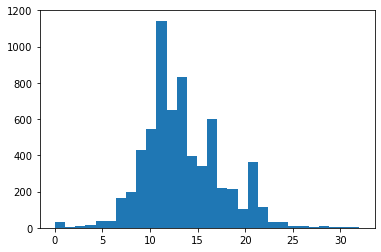

In [16]:
totalNumWords = [len(one_comment) for one_comment in X_train]
plt.hist(totalNumWords,bins = 30)
plt.show()

In [17]:
from tensorflow.keras.preprocessing import sequence
max_words = 100 # número máximo de palavras em um comentário
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(6559, 100) (1640, 100)


### Variáveis

In [18]:
batch_size = 256
epochs = 30
max_features = 30000 # número máximo de palavras utilizado para o vocabulário (número de "vetores de palavras")
init_lr = 1e-2
seed = 100

### Callbacks

In [19]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
es = EarlyStopping(patience=5, restore_best_weights=True, verbose = True, monitor='val_loss', mode='min')
mc = ModelCheckpoint(filepath='best_model.h10', save_best_only=True, verbose=True, monitor='val_loss', mode='min')
rlr = ReduceLROnPlateau(patience = 2, verbose = True, factor=0.5, monitor='val_loss', restore_best_weights=True, mode='min')

### Otimizador

In [20]:
opt = Adam(learning_rate=init_lr)

# CNN-LSTM

In [21]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report



In [22]:
def get_model(max_features, embed_dim):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))    
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['acc'])
    print(model.summary())
    return model

In [23]:
def model_train(model):
    # train the model
    model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2,callbacks=[es,rlr])
    # plot train history
    plot_model_history(model_history)

In [24]:
def model_train_mc(model):
    # train the model
    model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2,callbacks=[es,rlr,mc])
    # plot train history
    plot_model_history(model_history)

In [25]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [26]:
def model_evaluate(): 
     # predict class with test set
    # y_pred_test =  model.predict_classes(X_test, batch_size=batch_size, verbose=0) código
    # deprecatede não utiliza mais model.predict_classes
    
    y_pred_test =  model.predict(X_test) # novo formato para fazer a prvisão das classes
    y_pred_test = np.argmax(y_pred_test, axis=1) # converte para array
    
    #classification report
    print('\n')
    print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 10)           200000    
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 32)           992       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 3)                 3

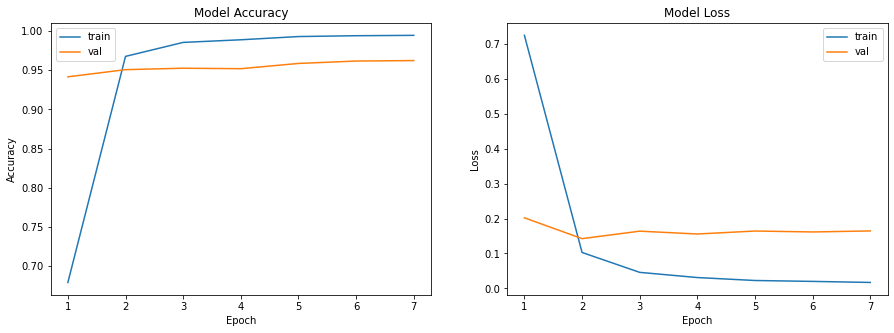

In [27]:
# train the model
max_features = 20000
embed_dim = 10
model = get_model(max_features, embed_dim)
model_train(model)



              precision    recall  f1-score   support

           0       0.92      0.97      0.94       489
           1       0.94      0.90      0.92       491
           2       0.98      0.97      0.98       660

    accuracy                           0.95      1640
   macro avg       0.95      0.95      0.95      1640
weighted avg       0.95      0.95      0.95      1640



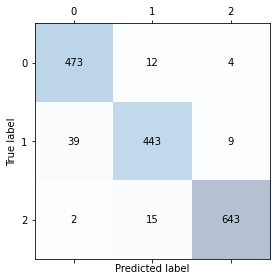

In [28]:
# evaluate model with test set
model_evaluate()

Agora vamos botar um moldelo pretreinado mas ele vai treinar junto

# glove_s100 + CNN-LSTM

In [29]:
from gensim.models import KeyedVectors

In [30]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features=max_features):
    # word vectors
#    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE,encoding='utf-8'))
 
    model = KeyedVectors.load_word2vec_format(EMBEDDING_FILE,limit=100)
    
    embeddings_index = {word: model[word] for word in model.index_to_key}
    
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) )
  #  print(num_words)
  #  print(max_features)
  #  print(len(word_index))
  #  print(len(embeddings_index)) 
    all_embs = np.stack(embeddings_index.values()) #for random init
    embedding_matrix = np.random.normal(all_embs.mean(), all_embs.std(), 
                                        (num_words, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return max_features, embedding_matrix

In [31]:
def get_model(max_features, embed_dim, embedding_matrix):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],
                       weights=[embedding_matrix]))#,trainable=False
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))    
    model.add(LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['acc'])
    print(model.summary())
    return model

In [32]:
#from google.colab import drive
#drive.mount('/content/drive')

import os
#workdir_path = '/content/drive/My Drive/'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
#os.chdir(workdir_path)

Found 100 word vectors.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          553300    
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 32)           9632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (No

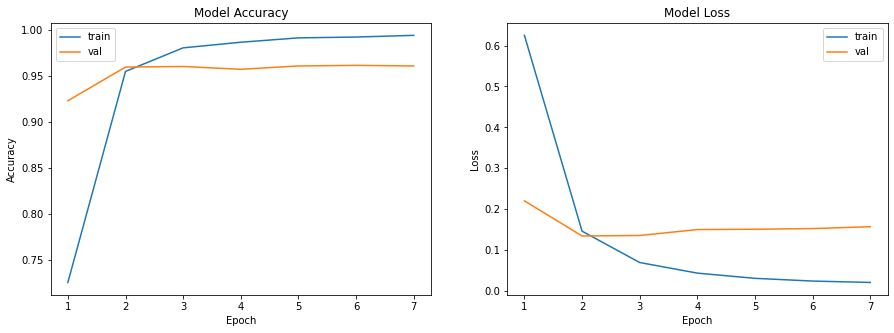

In [33]:
# embedding matrix
EMBEDDING_FILE ='../gloves/glove_s100.txt'

embed_dim = 100 #word vector dim
max_features, embedding_matrix = get_embed_mat(EMBEDDING_FILE)

# train the model
model = get_model(max_features, embed_dim, embedding_matrix)
model_train_mc(model)



              precision    recall  f1-score   support

           0       0.96      0.96      0.96       489
           1       0.92      0.95      0.94       491
           2       0.98      0.97      0.98       660

    accuracy                           0.96      1640
   macro avg       0.96      0.96      0.96      1640
weighted avg       0.96      0.96      0.96      1640



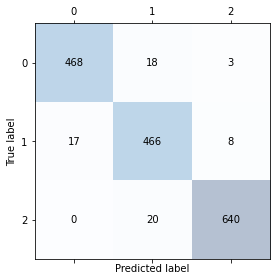

In [34]:
# evaluate model with test set
model_evaluate()

Agora congelanddo o modelo glove

In [35]:
def get_model(max_features, embed_dim, embedding_matrix):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],
                       weights=[embedding_matrix],trainable=True))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))    
    model.add(LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['acc'])
    print(model.summary())
    return model

Found 100 word vectors.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          553300    
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 32)           9632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (No

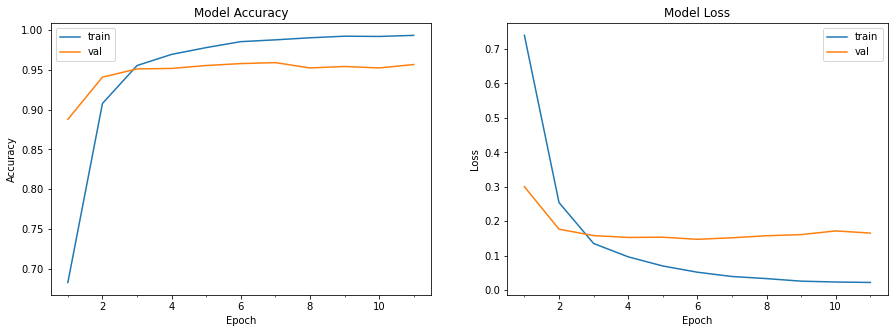

In [36]:
# embedding matrix

EMBEDDING_FILE ='../gloves/glove_s100.txt'

embed_dim = 100 #word vector dim
max_features, embedding_matrix = get_embed_mat(EMBEDDING_FILE)
# train the model
model = get_model(max_features, embed_dim, embedding_matrix)
model_train(model)



              precision    recall  f1-score   support

           0       0.94      0.96      0.95       489
           1       0.94      0.94      0.94       491
           2       0.98      0.97      0.98       660

    accuracy                           0.96      1640
   macro avg       0.96      0.96      0.96      1640
weighted avg       0.96      0.96      0.96      1640



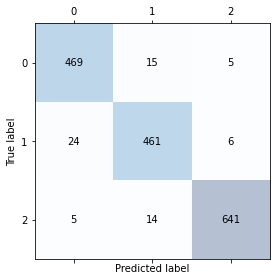

In [37]:
# evaluate model with test set
model_evaluate()